# Import các Packages cần thiết

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.backends.cudnn as cudnn
import numpy as np

import torchvision
from torchvision import datasets, models, transforms
from torchvision.transforms import InterpolationMode
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision.models import (EfficientNet_B0_Weights, EfficientNet_B1_Weights, EfficientNet_B2_Weights,EfficientNet_B3_Weights,
                                EfficientNet_V2_S_Weights)
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import copy
from PIL import Image
from pathlib import Path
from tqdm import tqdm
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score,precision_recall_fscore_support
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


# Xử lý ảnh kém chất lượng

In [ ]:
import cv2

input_root = "UTKFaces"   # base directory
min_width, min_height = 100, 100  # optional resolution threshold

records = []

def check_quality(img):
    """Return blur value, color variance, and resolution."""
    if img is None or img.size == 0:
        return None, None, None

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.Laplacian(gray, cv2.CV_64F).var()
    color_var = np.var(img)
    h, w = img.shape[:2]
    return blur, color_var, (w, h)

# === SCAN ALL IMAGES ===
for root, _, files in os.walk(input_root):
    for file in tqdm(files, desc=f"Checking {os.path.basename(root)}", leave=False):
        if not file.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue
        path = os.path.join(root, file)
        img = cv2.imread(path)

        # Handle missing/corrupt images
        if img is None:
            print(f"[WARN] Failed to read: {path}")
            continue

        blur, color_var, (w, h) = check_quality(img)
        records.append({
            "file": path,
            "width": w,
            "height": h,
            "blur": round(blur, 2) if blur is not None else None,
            "color_var": round(color_var, 2) if color_var is not None else None
        })

# === SAVE OR DISPLAY ===
df = pd.DataFrame(records)
print(df.describe())        
df.to_csv("image_quality_report.csv", index=False)
print("\n✅ Report saved as 'image_quality_report.csv'")

In [ ]:
import pandas as pd

input_root = "UTKFaces"        # your main dataset
output_root = "LowQualityFaces"    # destination for low-quality images
BLUR_THRESHOLD = 15
COLOR_THRESHOLD = 500

# === LOAD QUALITY REPORT ===
df = pd.read_csv("image_quality_report.csv")

# === SELECT LOW-QUALITY IMAGES ===
bad_images = df[(df['blur'] < BLUR_THRESHOLD) | (df['color_var'] < COLOR_THRESHOLD)]
print(f"Found {len(bad_images)} low-quality images.")

# === CREATE MIRRORED FOLDER STRUCTURE ===
for root, dirs, _ in os.walk(input_root):
    for d in dirs:
        os.makedirs(os.path.join(output_root, os.path.relpath(os.path.join(root, d), input_root)), exist_ok=True)

print(f"[INFO] Mirrored folder structure created in '{output_root}'")

# === MOVE LOW-QUALITY IMAGES ===
moved_count = 0
for f in tqdm(bad_images['file'], desc="Moving low-quality images"):
    src = f
    dst = os.path.join(output_root, os.path.relpath(f, input_root))
    try:
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.move(src, dst)
        moved_count += 1
    except Exception as e:
        print(f"[ERROR] {f}: {e}")

print(f"\n✅ Moved {moved_count} low-quality images to '{output_root}'")

# Functions hỗ trợ

In [29]:
def save_plots(train_acc, valid_acc, train_loss, valid_loss, eff_net):
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color='green', linestyle='-', 
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='blue', linestyle='-', 
        label='validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('outputs/'+eff_net+'/accuracy.png')
    
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='orange', linestyle='-', 
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-', 
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('outputs/'+eff_net+'/loss.png')

In [30]:
def save_model(epochs, model, optimizer, criterion):
    torch.save({
                'epoch': epochs,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, 'outputs/new/model_pytorch.pth')

In [31]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0, verbose=True, save_path=None):

        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.save_path = save_path
        self.counter = 0
        self.best_loss = np.inf
        self.early_stop = False

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            # Save the best model
            torch.save(model.state_dict(), self.save_path)
            if self.verbose:
                print(f"[INFO] Validation loss decreased. Saving model to {self.save_path}")
        else:
            self.counter += 1
            if self.verbose:
                print(f"[INFO] EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True


In [44]:
def train(model, train_loader, optimizer, criterion):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(train_loader), total=len(train_loader)):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        # Forward pass.
        outputs = model(image)
        # Calculate the loss.
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        # Calculate the accuracy.
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        # Update the weights.
        optimizer.step()
    
    # Loss and accuracy for the complete epoch.
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(train_loader.dataset))
    return epoch_loss, epoch_acc
# validation
def validate(model, valid_loader, criterion, tta=True):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(valid_loader), total=len(valid_loader)):
            counter += 1
            
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # Forward pass.
            outputs = model(image)
            # Calculate the loss.
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            # Calculate the accuracy.
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()
        
    # Loss and accuracy for the complete epoch.
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(valid_loader.dataset))
    return epoch_loss, epoch_acc


# Data loader/ Data Augmentation/ Weights Sampling

In [34]:
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.01, contrast=0.01),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

valid_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])



In [35]:
BATCH_SIZE = 64

In [36]:
train_dataset = datasets.ImageFolder(
    root= "train",
    transform=train_transform
)
# validation dataset

valid_dataset = datasets.ImageFolder(
    root='val',
    transform=valid_transform
)

In [ ]:
class_counts = Counter(train_dataset.targets)
class_names = train_dataset.classes
print(class_names)
for idx, class_name in enumerate(train_dataset.classes):
    print(f"{class_name}: {class_counts[idx]} images")

In [38]:
targets = np.array(train_dataset.targets)
class_counts = np.bincount(targets)
class_weights = 1.0 / class_counts
sample_weights = class_weights[targets]

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

In [39]:
train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, sampler=sampler, 
    num_workers=4, pin_memory=True
)
valid_loader = DataLoader(
    valid_dataset, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=4, pin_memory=True
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


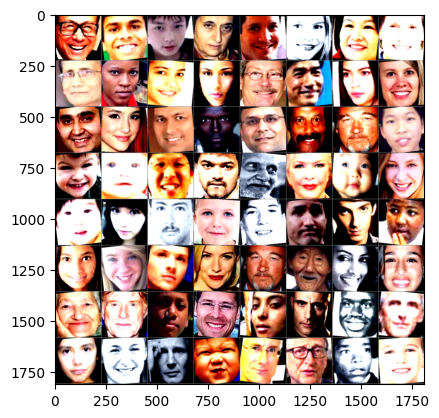

In [17]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
# print labels

# EfficientNet-B0

In [40]:
weights = EfficientNet_B0_Weights.IMAGENET1K_V1
model_ft = torchvision.models.efficientnet_b0(weights=weights)

for param in model_ft.parameters():
    param.requires_grad = False


in_features = model_ft.classifier[1].in_features
model_ft.classifier = nn.Sequential(
    nn.Dropout(0.4),
    nn.Linear(in_features, 512),   # compress features
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, 5)              # final classes
)

model_ft

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [43]:
print(f"Computation device: {device}\n")
model = model_ft.to(device)
for param in model.parameters():
    param.requires_grad = False

# Unfreeze last N blocks
for param in model.features[-4:].parameters():   # last 2 blocks
    param.requires_grad = True
    
# total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

optimizer = optim.AdamW([
    {"params": model.features.parameters(), "lr": 1e-4},
    {"params": model.classifier.parameters(), "lr": 1e-3}
])

# loss function
criterion = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5,min_lr=1e-8)

Computation device: cuda

4,665,985 total parameters.
3,698,888 training parameters.



[INFO] Epoch 1/50
Training


100%|████████████████████████████████████████████████████████████████████████████████| 260/260 [01:14<00:00,  3.50it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:07<00:00,  7.99it/s]


Training loss: 1.2199, acc: 52.61%
Validation loss: 0.8105, acc: 72.24%
Learning rate: 0.000100
Learning rate: 0.001000
[INFO] Validation loss decreased. Saving model to outputs/B0/best_model.pt

[INFO] Epoch 2/50
Training


100%|████████████████████████████████████████████████████████████████████████████████| 260/260 [01:13<00:00,  3.55it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:06<00:00,  8.25it/s]


Training loss: 0.7805, acc: 69.92%
Validation loss: 0.7277, acc: 72.92%
Learning rate: 0.000100
Learning rate: 0.001000
[INFO] Validation loss decreased. Saving model to outputs/B0/best_model.pt

[INFO] Epoch 3/50
Training


100%|████████████████████████████████████████████████████████████████████████████████| 260/260 [01:09<00:00,  3.72it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:06<00:00,  8.15it/s]


Training loss: 0.6647, acc: 74.42%
Validation loss: 0.7008, acc: 72.55%
Learning rate: 0.000100
Learning rate: 0.001000
[INFO] Validation loss decreased. Saving model to outputs/B0/best_model.pt

[INFO] Epoch 4/50
Training


100%|████████████████████████████████████████████████████████████████████████████████| 260/260 [01:10<00:00,  3.70it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:06<00:00,  8.25it/s]


Training loss: 0.5988, acc: 77.00%
Validation loss: 0.6277, acc: 75.90%
Learning rate: 0.000100
Learning rate: 0.001000
[INFO] Validation loss decreased. Saving model to outputs/B0/best_model.pt

[INFO] Epoch 5/50
Training


100%|████████████████████████████████████████████████████████████████████████████████| 260/260 [01:10<00:00,  3.70it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:06<00:00,  8.12it/s]


Training loss: 0.5533, acc: 79.08%
Validation loss: 0.6410, acc: 74.77%
Learning rate: 0.000100
Learning rate: 0.001000
[INFO] EarlyStopping counter: 1 out of 8

[INFO] Epoch 6/50
Training


100%|████████████████████████████████████████████████████████████████████████████████| 260/260 [01:10<00:00,  3.70it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:06<00:00,  8.20it/s]


Training loss: 0.5036, acc: 81.19%
Validation loss: 0.6301, acc: 75.76%
Learning rate: 0.000100
Learning rate: 0.001000
[INFO] EarlyStopping counter: 2 out of 8

[INFO] Epoch 7/50
Training


100%|████████████████████████████████████████████████████████████████████████████████| 260/260 [01:10<00:00,  3.69it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:06<00:00,  8.36it/s]


Training loss: 0.4777, acc: 82.06%
Validation loss: 0.6776, acc: 73.85%
Learning rate: 0.000100
Learning rate: 0.001000
[INFO] EarlyStopping counter: 3 out of 8

[INFO] Epoch 8/50
Training


100%|████████████████████████████████████████████████████████████████████████████████| 260/260 [01:09<00:00,  3.72it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:06<00:00,  8.20it/s]


Training loss: 0.4427, acc: 83.80%
Validation loss: 0.6237, acc: 76.32%
Learning rate: 0.000100
Learning rate: 0.001000
[INFO] Validation loss decreased. Saving model to outputs/B0/best_model.pt

[INFO] Epoch 9/50
Training


100%|████████████████████████████████████████████████████████████████████████████████| 260/260 [01:10<00:00,  3.70it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:06<00:00,  8.16it/s]


Training loss: 0.4090, acc: 85.44%
Validation loss: 0.5922, acc: 77.53%
Learning rate: 0.000100
Learning rate: 0.001000
[INFO] Validation loss decreased. Saving model to outputs/B0/best_model.pt

[INFO] Epoch 10/50
Training


100%|████████████████████████████████████████████████████████████████████████████████| 260/260 [01:09<00:00,  3.73it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:06<00:00,  8.41it/s]


Training loss: 0.3995, acc: 85.58%
Validation loss: 0.6082, acc: 77.34%
Learning rate: 0.000100
Learning rate: 0.001000
[INFO] EarlyStopping counter: 1 out of 8

[INFO] Epoch 11/50
Training


100%|████████████████████████████████████████████████████████████████████████████████| 260/260 [01:10<00:00,  3.69it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:06<00:00,  8.19it/s]


Training loss: 0.3696, acc: 86.79%
Validation loss: 0.6060, acc: 77.62%
Learning rate: 0.000100
Learning rate: 0.001000
[INFO] EarlyStopping counter: 2 out of 8

[INFO] Epoch 12/50
Training


100%|████████████████████████████████████████████████████████████████████████████████| 260/260 [01:10<00:00,  3.70it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:06<00:00,  8.12it/s]


Training loss: 0.3572, acc: 87.03%
Validation loss: 0.6348, acc: 76.69%
Learning rate: 0.000100
Learning rate: 0.001000
[INFO] EarlyStopping counter: 3 out of 8

[INFO] Epoch 13/50
Training


100%|████████████████████████████████████████████████████████████████████████████████| 260/260 [04:39<00:00,  1.08s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:06<00:00,  8.07it/s]


Training loss: 0.3322, acc: 88.47%
Validation loss: 0.6387, acc: 76.21%
Learning rate: 0.000100
Learning rate: 0.001000
[INFO] EarlyStopping counter: 4 out of 8

[INFO] Epoch 14/50
Training


100%|████████████████████████████████████████████████████████████████████████████████| 260/260 [01:10<00:00,  3.69it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:06<00:00,  8.14it/s]


Training loss: 0.3170, acc: 89.16%
Validation loss: 0.6296, acc: 77.70%
Learning rate: 0.000100
Learning rate: 0.001000
[INFO] EarlyStopping counter: 5 out of 8

[INFO] Epoch 15/50
Training


100%|████████████████████████████████████████████████████████████████████████████████| 260/260 [01:09<00:00,  3.76it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:06<00:00,  8.21it/s]


Training loss: 0.3048, acc: 89.44%
Validation loss: 0.6478, acc: 77.03%
Learning rate: 0.000050
Learning rate: 0.000500
[INFO] EarlyStopping counter: 6 out of 8

[INFO] Epoch 16/50
Training


100%|████████████████████████████████████████████████████████████████████████████████| 260/260 [01:09<00:00,  3.74it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:06<00:00,  8.29it/s]


Training loss: 0.2780, acc: 90.18%
Validation loss: 0.6364, acc: 77.14%
Learning rate: 0.000050
Learning rate: 0.000500
[INFO] EarlyStopping counter: 7 out of 8

[INFO] Epoch 17/50
Training


100%|████████████████████████████████████████████████████████████████████████████████| 260/260 [01:08<00:00,  3.77it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:06<00:00,  8.33it/s]


Training loss: 0.2649, acc: 90.92%
Validation loss: 0.6275, acc: 78.24%
Learning rate: 0.000050
Learning rate: 0.000500
[INFO] EarlyStopping counter: 8 out of 8
[INFO] Early stopping triggered.
TRAINING COMPLETE


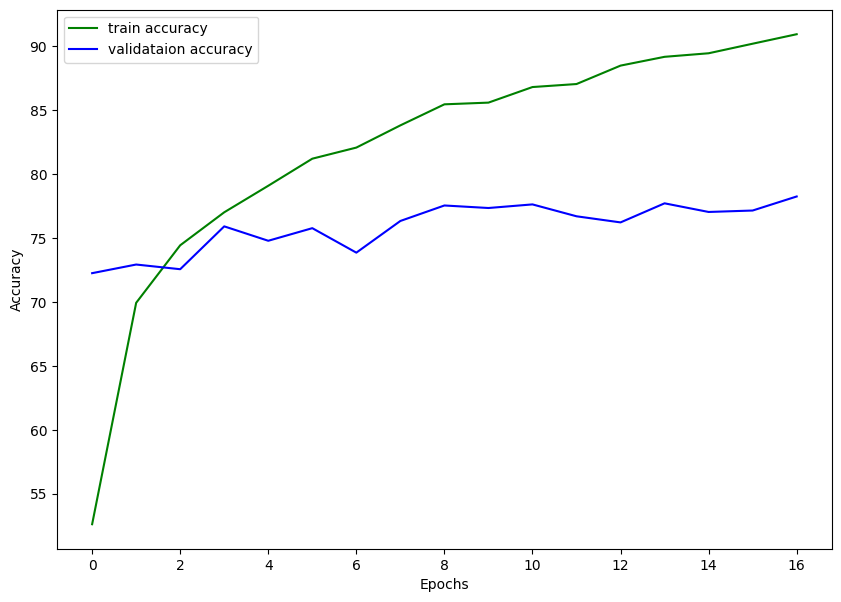

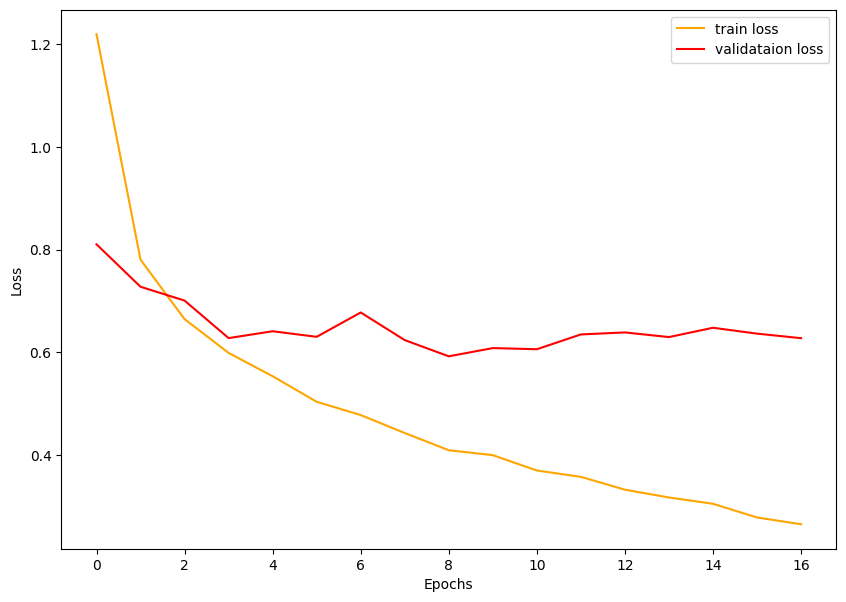

In [45]:
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
early_stopping = EarlyStopping(patience=8, min_delta=0.001, save_path='outputs/B0/best_model.pt')
epochs = 50
for epoch in range(epochs):
    print(f"\n[INFO] Epoch {epoch+1}/{epochs}")

    train_epoch_loss, train_epoch_acc = train(model, train_loader, optimizer, criterion)
    valid_epoch_loss, valid_epoch_acc = validate(model, valid_loader, criterion)

    scheduler.step(valid_epoch_loss)

    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)

    print(f"Training loss: {train_epoch_loss:.4f}, acc: {train_epoch_acc:.2f}%")
    print(f"Validation loss: {valid_epoch_loss:.4f}, acc: {valid_epoch_acc:.2f}%")
    for g in optimizer.param_groups:
        print(f"Learning rate: {g['lr']:.6f}")

    # Early stopping
    early_stopping(valid_epoch_loss, model)
    if early_stopping.early_stop:
        print("[INFO] Early stopping triggered.")
        break
# save the trained model weights
save_model(epochs, model, optimizer, criterion)
# save the loss and accuracy plots
save_plots(train_acc, valid_acc, train_loss, valid_loss,eff_net='B0')
print('TRAINING COMPLETE')

Accuracy: 0.7968591691995948
                precision    recall  f1-score   support

Người lớn tuổi       0.81      0.70      0.75       240
    Thanh niên       0.87      0.86      0.87       956
    Thiếu niên       0.54      0.48      0.51       106
    Trung niên       0.61      0.70      0.65       383
        Trẻ em       0.92      0.91      0.91       289

      accuracy                           0.80      1974
     macro avg       0.75      0.73      0.74      1974
  weighted avg       0.80      0.80      0.80      1974



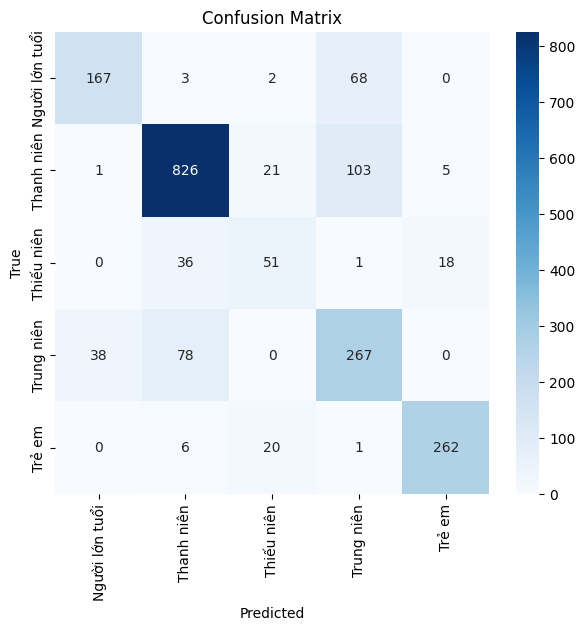

In [21]:
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_ft(images)
        preds = torch.argmax(outputs, dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Metrics
class_names = valid_dataset.classes
print("Accuracy:", accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# EfficientNet-B3

In [12]:
weights = EfficientNet_B3_Weights.IMAGENET1K_V1
model_ft = torchvision.models.efficientnet_b3(weights=weights)

for param in model_ft.parameters():
    param.requires_grad = False


in_features = model_ft.classifier[1].in_features
model_ft.classifier = nn.Sequential(
    nn.Dropout(0.4),
    nn.Linear(in_features, 768),   # compress features
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(768, 5)              # final classes
)

model_ft

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [13]:
print(f"Computation device: {device}\n")
model = model_ft.to(device)
for param in model.parameters():
    param.requires_grad = False

# Unfreeze last N blocks
for param in model.features[-4:].parameters():   # last 2 blocks
    param.requires_grad = True
    
# total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

optimizer = optim.AdamW([
    {"params": model.features.parameters(), "lr": 5e-5},
    {"params": model.classifier.parameters(), "lr": 1e-3}
])

# loss function
criterion = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5,min_lr=1e-8)

Computation device: cuda

11,880,493 total parameters.
9,893,838 training parameters.



[INFO] Epoch 1/50
Training


100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [00:44<00:00,  5.59it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:04<00:00,  7.27it/s]


Training loss: 1.4230, acc: 43.86%
Validation loss: 1.0666, acc: 59.32%
Learning rate: 0.000050
Learning rate: 0.001000
[INFO] Validation loss decreased. Saving model to outputs/B3/best_model.pt

[INFO] Epoch 2/50
Training


100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [00:43<00:00,  5.73it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:04<00:00,  6.89it/s]


Training loss: 0.8758, acc: 67.90%
Validation loss: 0.7775, acc: 70.52%
Learning rate: 0.000050
Learning rate: 0.001000
[INFO] Validation loss decreased. Saving model to outputs/B3/best_model.pt

[INFO] Epoch 3/50
Training


100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [00:43<00:00,  5.68it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:04<00:00,  7.14it/s]


Training loss: 0.6921, acc: 74.02%
Validation loss: 0.6710, acc: 74.47%
Learning rate: 0.000050
Learning rate: 0.001000
[INFO] Validation loss decreased. Saving model to outputs/B3/best_model.pt

[INFO] Epoch 4/50
Training


100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [00:43<00:00,  5.70it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:04<00:00,  7.04it/s]


Training loss: 0.6043, acc: 77.54%
Validation loss: 0.6296, acc: 75.18%
Learning rate: 0.000050
Learning rate: 0.001000
[INFO] Validation loss decreased. Saving model to outputs/B3/best_model.pt

[INFO] Epoch 5/50
Training


100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [00:43<00:00,  5.73it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:04<00:00,  7.09it/s]


Training loss: 0.5527, acc: 79.11%
Validation loss: 0.6236, acc: 75.33%
Learning rate: 0.000050
Learning rate: 0.001000
[INFO] Validation loss decreased. Saving model to outputs/B3/best_model.pt

[INFO] Epoch 6/50
Training


100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [00:43<00:00,  5.73it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:04<00:00,  7.21it/s]


Training loss: 0.5052, acc: 81.04%
Validation loss: 0.6083, acc: 75.94%
Learning rate: 0.000050
Learning rate: 0.001000
[INFO] Validation loss decreased. Saving model to outputs/B3/best_model.pt

[INFO] Epoch 7/50
Training


100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [00:43<00:00,  5.72it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:04<00:00,  7.60it/s]


Training loss: 0.4585, acc: 83.18%
Validation loss: 0.6147, acc: 75.99%
Learning rate: 0.000050
Learning rate: 0.001000
[INFO] EarlyStopping counter: 1 out of 12

[INFO] Epoch 8/50
Training


100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [00:43<00:00,  5.72it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:04<00:00,  7.29it/s]


Training loss: 0.4236, acc: 84.78%
Validation loss: 0.5855, acc: 77.15%
Learning rate: 0.000050
Learning rate: 0.001000
[INFO] Validation loss decreased. Saving model to outputs/B3/best_model.pt

[INFO] Epoch 9/50
Training


100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [00:43<00:00,  5.69it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:04<00:00,  7.09it/s]


Training loss: 0.3921, acc: 86.00%
Validation loss: 0.5836, acc: 77.86%
Learning rate: 0.000050
Learning rate: 0.001000
[INFO] Validation loss decreased. Saving model to outputs/B3/best_model.pt

[INFO] Epoch 10/50
Training


100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [00:43<00:00,  5.72it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:04<00:00,  7.24it/s]


Training loss: 0.3618, acc: 87.03%
Validation loss: 0.5853, acc: 77.61%
Learning rate: 0.000050
Learning rate: 0.001000
[INFO] EarlyStopping counter: 1 out of 12

[INFO] Epoch 11/50
Training


100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [00:43<00:00,  5.72it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:04<00:00,  7.09it/s]


Training loss: 0.3374, acc: 88.40%
Validation loss: 0.5742, acc: 78.67%
Learning rate: 0.000050
Learning rate: 0.001000
[INFO] Validation loss decreased. Saving model to outputs/B3/best_model.pt

[INFO] Epoch 12/50
Training


100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [00:43<00:00,  5.69it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:04<00:00,  7.04it/s]


Training loss: 0.3222, acc: 88.90%
Validation loss: 0.6292, acc: 76.80%
Learning rate: 0.000050
Learning rate: 0.001000
[INFO] EarlyStopping counter: 1 out of 12

[INFO] Epoch 13/50
Training


100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [00:43<00:00,  5.72it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:04<00:00,  6.89it/s]


Training loss: 0.3098, acc: 89.56%
Validation loss: 0.6084, acc: 77.71%
Learning rate: 0.000050
Learning rate: 0.001000
[INFO] EarlyStopping counter: 2 out of 12

[INFO] Epoch 14/50
Training


100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [00:43<00:00,  5.72it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:04<00:00,  7.19it/s]


Training loss: 0.2830, acc: 90.36%
Validation loss: 0.5741, acc: 79.18%
Learning rate: 0.000050
Learning rate: 0.001000
[INFO] EarlyStopping counter: 3 out of 12

[INFO] Epoch 15/50
Training


100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [00:43<00:00,  5.69it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:04<00:00,  7.24it/s]


Training loss: 0.2778, acc: 90.34%
Validation loss: 0.6122, acc: 78.37%
Learning rate: 0.000050
Learning rate: 0.001000
[INFO] EarlyStopping counter: 4 out of 12

[INFO] Epoch 16/50
Training


100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [00:43<00:00,  5.73it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:04<00:00,  7.21it/s]


Training loss: 0.2534, acc: 91.41%
Validation loss: 0.6212, acc: 79.08%
Learning rate: 0.000050
Learning rate: 0.001000
[INFO] EarlyStopping counter: 5 out of 12

[INFO] Epoch 17/50
Training


100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [00:43<00:00,  5.69it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:04<00:00,  7.09it/s]


Training loss: 0.2417, acc: 92.17%
Validation loss: 0.6054, acc: 78.67%
Learning rate: 0.000050
Learning rate: 0.001000
[INFO] EarlyStopping counter: 6 out of 12

[INFO] Epoch 18/50
Training


100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [00:43<00:00,  5.72it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:04<00:00,  7.07it/s]


Training loss: 0.2399, acc: 91.87%
Validation loss: 0.5985, acc: 79.38%
Learning rate: 0.000050
Learning rate: 0.001000
[INFO] EarlyStopping counter: 7 out of 12

[INFO] Epoch 19/50
Training


100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [00:42<00:00,  5.75it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:04<00:00,  7.06it/s]


Training loss: 0.2182, acc: 92.83%
Validation loss: 0.6134, acc: 79.33%
Learning rate: 0.000050
Learning rate: 0.001000
[INFO] EarlyStopping counter: 8 out of 12

[INFO] Epoch 20/50
Training


100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [00:43<00:00,  5.66it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:04<00:00,  7.38it/s]


Training loss: 0.2119, acc: 92.91%
Validation loss: 0.6050, acc: 80.24%
Learning rate: 0.000025
Learning rate: 0.000500
[INFO] EarlyStopping counter: 9 out of 12

[INFO] Epoch 21/50
Training


100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [00:43<00:00,  5.72it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:04<00:00,  7.32it/s]


Training loss: 0.1984, acc: 93.80%
Validation loss: 0.6161, acc: 79.38%
Learning rate: 0.000025
Learning rate: 0.000500
[INFO] EarlyStopping counter: 10 out of 12

[INFO] Epoch 22/50
Training


100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [00:43<00:00,  5.72it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:04<00:00,  7.19it/s]


Training loss: 0.1905, acc: 93.95%
Validation loss: 0.6242, acc: 79.74%
Learning rate: 0.000025
Learning rate: 0.000500
[INFO] EarlyStopping counter: 11 out of 12

[INFO] Epoch 23/50
Training


100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [00:43<00:00,  5.73it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:04<00:00,  7.29it/s]


Training loss: 0.1891, acc: 94.05%
Validation loss: 0.6344, acc: 79.84%
Learning rate: 0.000025
Learning rate: 0.000500
[INFO] EarlyStopping counter: 12 out of 12
[INFO] Early stopping triggered.
TRAINING COMPLETE


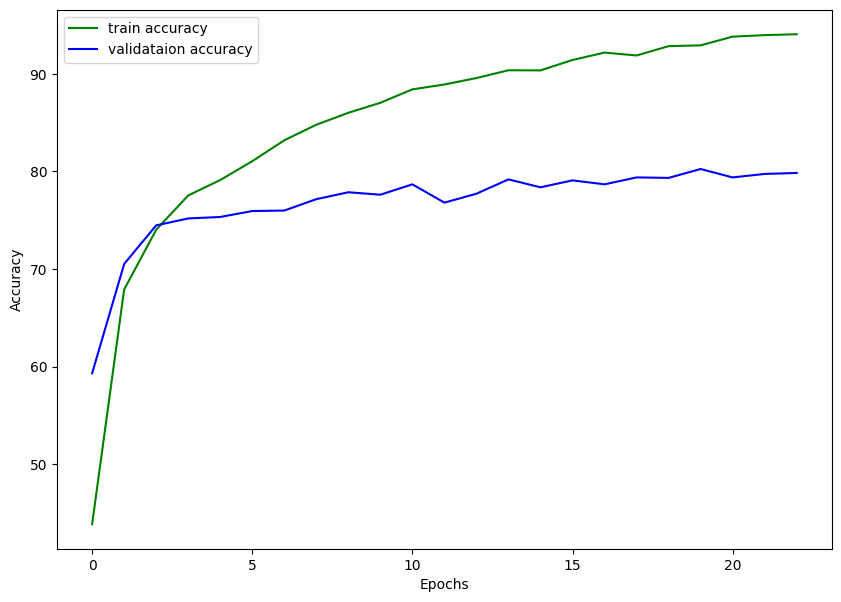

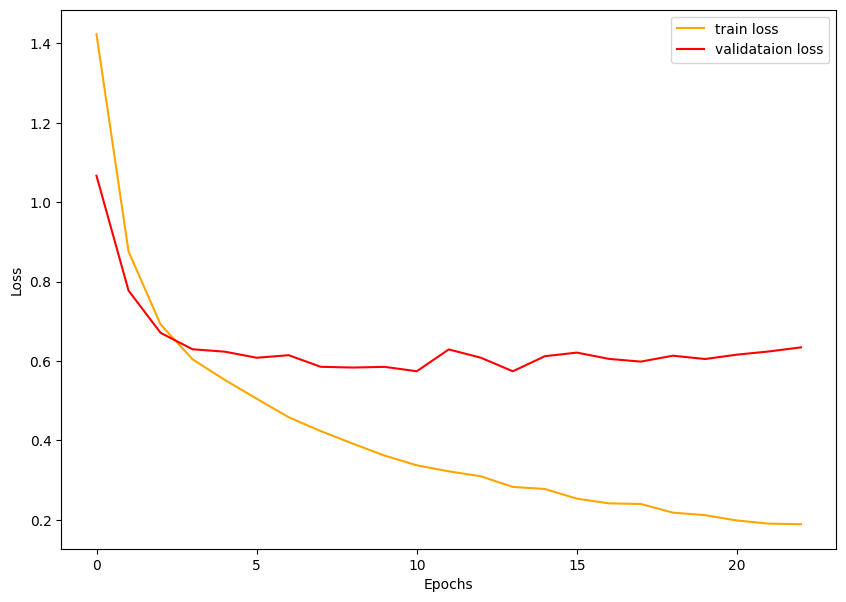

In [14]:
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5,min_lr=1e-8)
early_stopping = EarlyStopping(patience=12, min_delta=0.001, save_path='outputs/B3/best_model.pt')
epochs = 50
for epoch in range(epochs):
    print(f"\n[INFO] Epoch {epoch+1}/{epochs}")

    train_epoch_loss, train_epoch_acc = train(model, train_loader, optimizer, criterion)
    valid_epoch_loss, valid_epoch_acc = validate(model, valid_loader, criterion)

    scheduler.step(valid_epoch_loss)

    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)

    print(f"Training loss: {train_epoch_loss:.4f}, acc: {train_epoch_acc:.2f}%")
    print(f"Validation loss: {valid_epoch_loss:.4f}, acc: {valid_epoch_acc:.2f}%")
    for g in optimizer.param_groups:
        print(f"Learning rate: {g['lr']:.6f}")

    # Early stopping
    early_stopping(valid_epoch_loss, model)
    if early_stopping.early_stop:
        print("[INFO] Early stopping triggered.")
        break
# save the trained model weights
save_model(epochs, model, optimizer, criterion)
# save the loss and accuracy plots
save_plots(train_acc, valid_acc, train_loss, valid_loss,eff_net='B3')
print('TRAINING COMPLETE')

Accuracy: 0.7983789260385005
                precision    recall  f1-score   support

Người lớn tuổi       0.82      0.72      0.77       240
    Thanh niên       0.89      0.83      0.86       956
    Thiếu niên       0.58      0.53      0.55       106
    Trung niên       0.59      0.74      0.66       383
        Trẻ em       0.92      0.93      0.93       289

      accuracy                           0.80      1974
     macro avg       0.76      0.75      0.75      1974
  weighted avg       0.81      0.80      0.80      1974



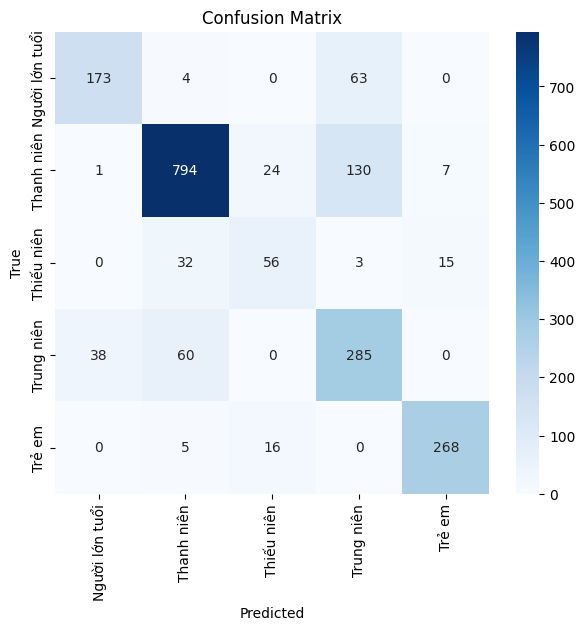

In [15]:
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_ft(images)
        preds = torch.argmax(outputs, dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Metrics
class_names = valid_dataset.classes
print("Accuracy:", accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# ViT-B16

In [27]:
from torchvision.models.vision_transformer import vit_b_16, ViT_B_16_Weights

vit = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)

# Freeze patch embeddings + transformer encoder
for param in vit.parameters():
    param.requires_grad = False

# Replace head
in_features = vit.heads.head.in_features
vit.heads.head = nn.Linear(in_features, 5)

# Unfreeze last transformer block
for param in vit.encoder.layers[-3:].parameters():
    param.requires_grad = True
for param in vit.heads.parameters():
    param.requires_grad = True
model = vit.to(device)

optimizer = optim.AdamW([
    {"params": model.encoder.layers[-3:].parameters(), "lr": 1e-4},
    {"params": model.heads.parameters(),              "lr": 1e-3},
])
criterion = nn.CrossEntropyLoss()
model

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [28]:
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")


85,802,501 total parameters.
21,267,461 training parameters.



[INFO] Epoch 1/50
Training


100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [01:05<00:00,  3.77it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:06<00:00,  4.80it/s]


Training loss: 0.7270, acc: 69.32%
Validation loss: 0.7543, acc: 69.55%
Learning rate: 0.000100
Learning rate: 0.001000
[INFO] Validation loss decreased. Saving model to outputs/vit16/best_model.pt

[INFO] Epoch 2/50
Training


100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [01:06<00:00,  3.72it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:06<00:00,  4.83it/s]


Training loss: 0.5210, acc: 78.24%
Validation loss: 0.7798, acc: 67.98%
Learning rate: 0.000100
Learning rate: 0.001000
[INFO] EarlyStopping counter: 1 out of 12

[INFO] Epoch 3/50
Training


100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [01:06<00:00,  3.71it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:06<00:00,  4.82it/s]


Training loss: 0.3960, acc: 83.80%
Validation loss: 0.9134, acc: 67.38%
Learning rate: 0.000100
Learning rate: 0.001000
[INFO] EarlyStopping counter: 2 out of 12

[INFO] Epoch 4/50
Training


100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [01:06<00:00,  3.70it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:06<00:00,  4.94it/s]


Training loss: 0.3189, acc: 87.22%
Validation loss: 0.6777, acc: 75.03%
Learning rate: 0.000100
Learning rate: 0.001000
[INFO] Validation loss decreased. Saving model to outputs/vit16/best_model.pt

[INFO] Epoch 5/50
Training


100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [01:06<00:00,  3.72it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:06<00:00,  4.79it/s]


Training loss: 0.2420, acc: 90.69%
Validation loss: 0.8092, acc: 75.23%
Learning rate: 0.000100
Learning rate: 0.001000
[INFO] EarlyStopping counter: 1 out of 12

[INFO] Epoch 6/50
Training


100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [01:06<00:00,  3.72it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:06<00:00,  4.84it/s]


Training loss: 0.2005, acc: 92.45%
Validation loss: 0.8756, acc: 73.61%
Learning rate: 0.000100
Learning rate: 0.001000
[INFO] EarlyStopping counter: 2 out of 12

[INFO] Epoch 7/50
Training


100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [01:06<00:00,  3.73it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:06<00:00,  4.87it/s]


Training loss: 0.1633, acc: 93.95%
Validation loss: 0.8350, acc: 76.14%
Learning rate: 0.000100
Learning rate: 0.001000
[INFO] EarlyStopping counter: 3 out of 12

[INFO] Epoch 8/50
Training


100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [01:06<00:00,  3.73it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:06<00:00,  4.89it/s]


Training loss: 0.1224, acc: 95.45%
Validation loss: 0.9507, acc: 75.68%
Learning rate: 0.000100
Learning rate: 0.001000
[INFO] EarlyStopping counter: 4 out of 12

[INFO] Epoch 9/50
Training


100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [01:06<00:00,  3.74it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:06<00:00,  4.82it/s]


Training loss: 0.1064, acc: 96.15%
Validation loss: 0.9742, acc: 76.34%
Learning rate: 0.000100
Learning rate: 0.001000
[INFO] EarlyStopping counter: 5 out of 12

[INFO] Epoch 10/50
Training


100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [01:06<00:00,  3.72it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:06<00:00,  4.78it/s]


Training loss: 0.1014, acc: 96.10%
Validation loss: 1.0897, acc: 74.92%
Learning rate: 0.000050
Learning rate: 0.000500
[INFO] EarlyStopping counter: 6 out of 12

[INFO] Epoch 11/50
Training


100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [01:06<00:00,  3.71it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:06<00:00,  4.69it/s]


Training loss: 0.0594, acc: 98.01%
Validation loss: 1.1373, acc: 75.43%
Learning rate: 0.000050
Learning rate: 0.000500
[INFO] EarlyStopping counter: 7 out of 12

[INFO] Epoch 12/50
Training


100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [01:06<00:00,  3.74it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:06<00:00,  4.76it/s]


Training loss: 0.0453, acc: 98.49%
Validation loss: 1.1486, acc: 75.58%
Learning rate: 0.000050
Learning rate: 0.000500
[INFO] EarlyStopping counter: 8 out of 12

[INFO] Epoch 13/50
Training


100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [01:06<00:00,  3.73it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:06<00:00,  4.84it/s]


Training loss: 0.0405, acc: 98.71%
Validation loss: 1.1109, acc: 75.73%
Learning rate: 0.000050
Learning rate: 0.000500
[INFO] EarlyStopping counter: 9 out of 12

[INFO] Epoch 14/50
Training


100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [01:06<00:00,  3.73it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:06<00:00,  4.97it/s]


Training loss: 0.0370, acc: 98.79%
Validation loss: 1.2006, acc: 75.48%
Learning rate: 0.000050
Learning rate: 0.000500
[INFO] EarlyStopping counter: 10 out of 12

[INFO] Epoch 15/50
Training


100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [01:06<00:00,  3.71it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:06<00:00,  4.83it/s]


Training loss: 0.0314, acc: 99.11%
Validation loss: 1.2295, acc: 76.14%
Learning rate: 0.000050
Learning rate: 0.000500
[INFO] EarlyStopping counter: 11 out of 12

[INFO] Epoch 16/50
Training


100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [01:06<00:00,  3.72it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:06<00:00,  4.78it/s]


Training loss: 0.0272, acc: 99.15%
Validation loss: 1.2243, acc: 75.58%
Learning rate: 0.000025
Learning rate: 0.000250
[INFO] EarlyStopping counter: 12 out of 12
[INFO] Early stopping triggered.
TRAINING COMPLETE


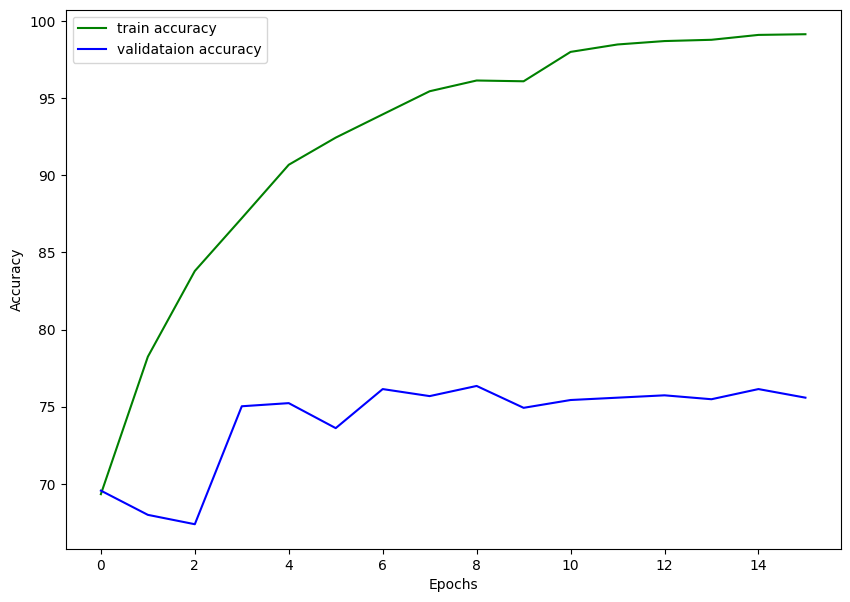

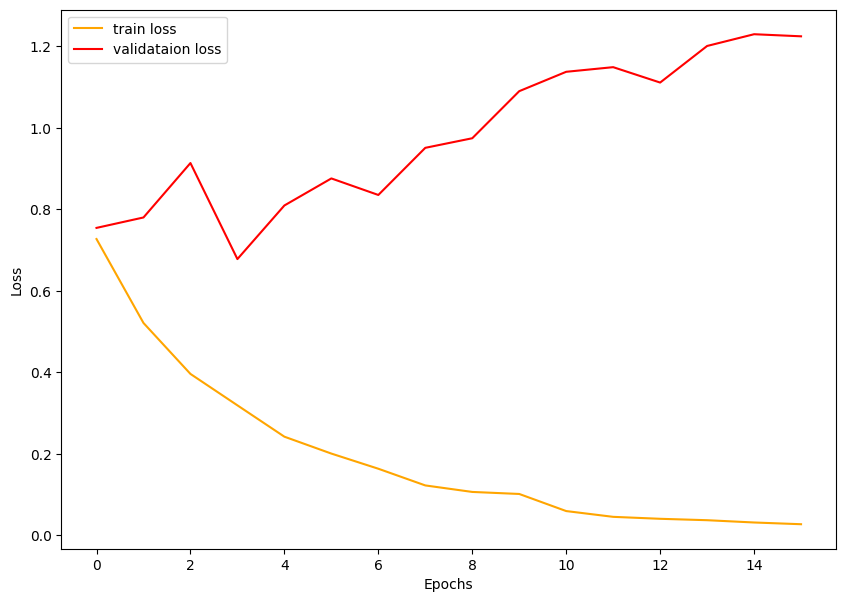

In [29]:
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5,min_lr=1e-8)
early_stopping = EarlyStopping(patience=12, min_delta=0.001, save_path='outputs/vit16/best_model.pt')
epochs = 50
for epoch in range(epochs):
    print(f"\n[INFO] Epoch {epoch+1}/{epochs}")

    train_epoch_loss, train_epoch_acc = train(model, train_loader, optimizer, criterion)
    valid_epoch_loss, valid_epoch_acc = validate(model, valid_loader, criterion)

    scheduler.step(valid_epoch_loss)

    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)

    print(f"Training loss: {train_epoch_loss:.4f}, acc: {train_epoch_acc:.2f}%")
    print(f"Validation loss: {valid_epoch_loss:.4f}, acc: {valid_epoch_acc:.2f}%")
    for g in optimizer.param_groups:
        print(f"Learning rate: {g['lr']:.6f}")

    # Early stopping
    early_stopping(valid_epoch_loss, model)
    if early_stopping.early_stop:
        print("[INFO] Early stopping triggered.")
        break
# save the trained model weights
save_model(epochs, model, optimizer, criterion)
# save the loss and accuracy plots
save_plots(train_acc, valid_acc, train_loss, valid_loss,eff_net='vit16')
print('TRAINING COMPLETE')

Accuracy: 0.7558257345491388
                precision    recall  f1-score   support

Người lớn tuổi       0.71      0.72      0.71       240
    Thanh niên       0.84      0.84      0.84       956
    Thiếu niên       0.54      0.40      0.46       106
    Trung niên       0.54      0.54      0.54       383
        Trẻ em       0.86      0.92      0.89       289

      accuracy                           0.76      1974
     macro avg       0.70      0.68      0.69      1974
  weighted avg       0.75      0.76      0.75      1974



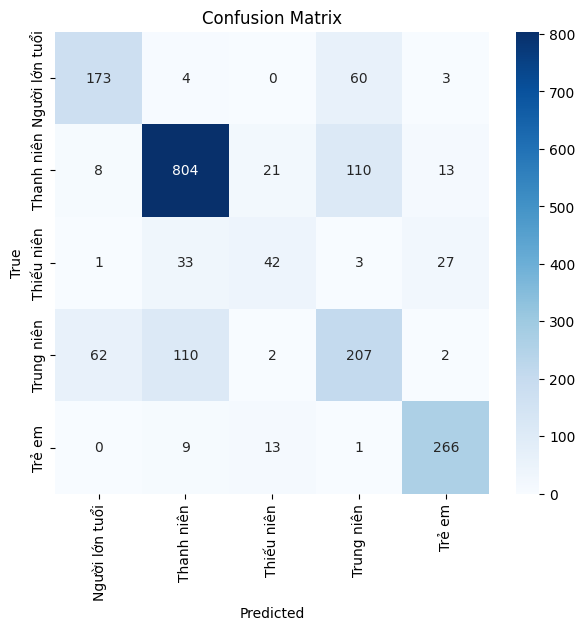

In [31]:
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Metrics
class_names = valid_dataset.classes
print("Accuracy:", accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# ResNet-18

In [13]:
resnet18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Freeze backbone
for param in resnet18.parameters():
    param.requires_grad = False

# Replace classifier
in_features = resnet18.fc.in_features
resnet18.fc = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, 5)
)

# Unfreeze last residual block (layer4)
for param in resnet18.parameters():
    param.requires_grad = True
model = resnet18.to(device)

optimizer = optim.AdamW([
    {"params": model.layer1.parameters(), "lr": 1e-5},
    {"params": model.layer2.parameters(), "lr": 3e-5},
    {"params": model.layer3.parameters(), "lr": 5e-5},
    {"params": model.layer4.parameters(), "lr": 1e-4},
    {"params": model.fc.parameters(), "lr": 1e-3},
],weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")


11,309,125 total parameters.
11,309,125 training parameters.



[INFO] Epoch 1/50
Training


100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [00:19<00:00, 12.58it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:02<00:00, 10.72it/s]


Training loss: 0.7658, acc: 67.68%
Validation loss: 1.0646, acc: 54.41%
Learning rate: 0.000010
Learning rate: 0.000030
Learning rate: 0.000050
Learning rate: 0.000100
Learning rate: 0.001000
[INFO] Validation loss decreased. Saving model to outputs/resnet18/best_model.pt

[INFO] Epoch 2/50
Training


100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [00:18<00:00, 13.40it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:02<00:00, 10.50it/s]


Training loss: 0.5354, acc: 77.53%
Validation loss: 0.7299, acc: 69.30%
Learning rate: 0.000010
Learning rate: 0.000030
Learning rate: 0.000050
Learning rate: 0.000100
Learning rate: 0.001000
[INFO] Validation loss decreased. Saving model to outputs/resnet18/best_model.pt

[INFO] Epoch 3/50
Training


100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [00:17<00:00, 13.81it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:02<00:00, 11.08it/s]


Training loss: 0.4440, acc: 81.76%
Validation loss: 0.7744, acc: 68.84%
Learning rate: 0.000010
Learning rate: 0.000030
Learning rate: 0.000050
Learning rate: 0.000100
Learning rate: 0.001000
[INFO] EarlyStopping counter: 1 out of 12

[INFO] Epoch 4/50
Training


100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [00:17<00:00, 14.19it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:02<00:00, 11.41it/s]


Training loss: 0.3698, acc: 85.10%
Validation loss: 0.7068, acc: 74.47%
Learning rate: 0.000010
Learning rate: 0.000030
Learning rate: 0.000050
Learning rate: 0.000100
Learning rate: 0.001000
[INFO] Validation loss decreased. Saving model to outputs/resnet18/best_model.pt

[INFO] Epoch 5/50
Training


100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [00:17<00:00, 14.23it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:02<00:00, 11.54it/s]


Training loss: 0.3177, acc: 87.51%
Validation loss: 0.7224, acc: 74.77%
Learning rate: 0.000010
Learning rate: 0.000030
Learning rate: 0.000050
Learning rate: 0.000100
Learning rate: 0.001000
[INFO] EarlyStopping counter: 1 out of 12

[INFO] Epoch 6/50
Training


100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [00:17<00:00, 14.15it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:02<00:00, 10.96it/s]


Training loss: 0.2849, acc: 88.77%
Validation loss: 0.7380, acc: 74.72%
Learning rate: 0.000010
Learning rate: 0.000030
Learning rate: 0.000050
Learning rate: 0.000100
Learning rate: 0.001000
[INFO] EarlyStopping counter: 2 out of 12

[INFO] Epoch 7/50
Training


100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [00:17<00:00, 13.94it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:02<00:00, 11.53it/s]


Training loss: 0.2369, acc: 91.07%
Validation loss: 0.7615, acc: 77.91%
Learning rate: 0.000010
Learning rate: 0.000030
Learning rate: 0.000050
Learning rate: 0.000100
Learning rate: 0.001000
[INFO] EarlyStopping counter: 3 out of 12

[INFO] Epoch 8/50
Training


100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [00:18<00:00, 13.67it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:02<00:00, 10.78it/s]


Training loss: 0.2232, acc: 91.35%
Validation loss: 0.7704, acc: 75.63%
Learning rate: 0.000010
Learning rate: 0.000030
Learning rate: 0.000050
Learning rate: 0.000100
Learning rate: 0.001000
[INFO] EarlyStopping counter: 4 out of 12

[INFO] Epoch 9/50
Training


100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [00:18<00:00, 13.23it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:02<00:00, 10.55it/s]


Training loss: 0.1956, acc: 92.69%
Validation loss: 0.8092, acc: 77.10%
Learning rate: 0.000010
Learning rate: 0.000030
Learning rate: 0.000050
Learning rate: 0.000100
Learning rate: 0.001000
[INFO] EarlyStopping counter: 5 out of 12

[INFO] Epoch 10/50
Training


100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [00:18<00:00, 13.14it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:02<00:00, 11.27it/s]


Training loss: 0.1663, acc: 93.88%
Validation loss: 0.9565, acc: 74.82%
Learning rate: 0.000005
Learning rate: 0.000015
Learning rate: 0.000025
Learning rate: 0.000050
Learning rate: 0.000500
[INFO] EarlyStopping counter: 6 out of 12

[INFO] Epoch 11/50
Training


100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [00:18<00:00, 13.05it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:02<00:00, 10.61it/s]


Training loss: 0.1342, acc: 94.90%
Validation loss: 0.9089, acc: 76.80%
Learning rate: 0.000005
Learning rate: 0.000015
Learning rate: 0.000025
Learning rate: 0.000050
Learning rate: 0.000500
[INFO] EarlyStopping counter: 7 out of 12

[INFO] Epoch 12/50
Training


100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [00:18<00:00, 13.33it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:02<00:00, 11.15it/s]


Training loss: 0.1067, acc: 96.29%
Validation loss: 0.9768, acc: 77.25%
Learning rate: 0.000005
Learning rate: 0.000015
Learning rate: 0.000025
Learning rate: 0.000050
Learning rate: 0.000500
[INFO] EarlyStopping counter: 8 out of 12

[INFO] Epoch 13/50
Training


100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [00:18<00:00, 13.64it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:02<00:00, 11.27it/s]


Training loss: 0.0923, acc: 96.66%
Validation loss: 0.9818, acc: 78.42%
Learning rate: 0.000005
Learning rate: 0.000015
Learning rate: 0.000025
Learning rate: 0.000050
Learning rate: 0.000500
[INFO] EarlyStopping counter: 9 out of 12

[INFO] Epoch 14/50
Training


100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [00:17<00:00, 13.90it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:02<00:00, 11.34it/s]


Training loss: 0.0891, acc: 96.92%
Validation loss: 1.0603, acc: 78.22%
Learning rate: 0.000005
Learning rate: 0.000015
Learning rate: 0.000025
Learning rate: 0.000050
Learning rate: 0.000500
[INFO] EarlyStopping counter: 10 out of 12

[INFO] Epoch 15/50
Training


100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [00:17<00:00, 13.95it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:02<00:00, 11.53it/s]


Training loss: 0.0794, acc: 97.12%
Validation loss: 1.0971, acc: 78.52%
Learning rate: 0.000005
Learning rate: 0.000015
Learning rate: 0.000025
Learning rate: 0.000050
Learning rate: 0.000500
[INFO] EarlyStopping counter: 11 out of 12

[INFO] Epoch 16/50
Training


100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [00:17<00:00, 13.88it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:02<00:00, 11.21it/s]


Training loss: 0.0769, acc: 97.29%
Validation loss: 1.1163, acc: 78.22%
Learning rate: 0.000003
Learning rate: 0.000008
Learning rate: 0.000013
Learning rate: 0.000025
Learning rate: 0.000250
[INFO] EarlyStopping counter: 12 out of 12
[INFO] Early stopping triggered.
TRAINING COMPLETE


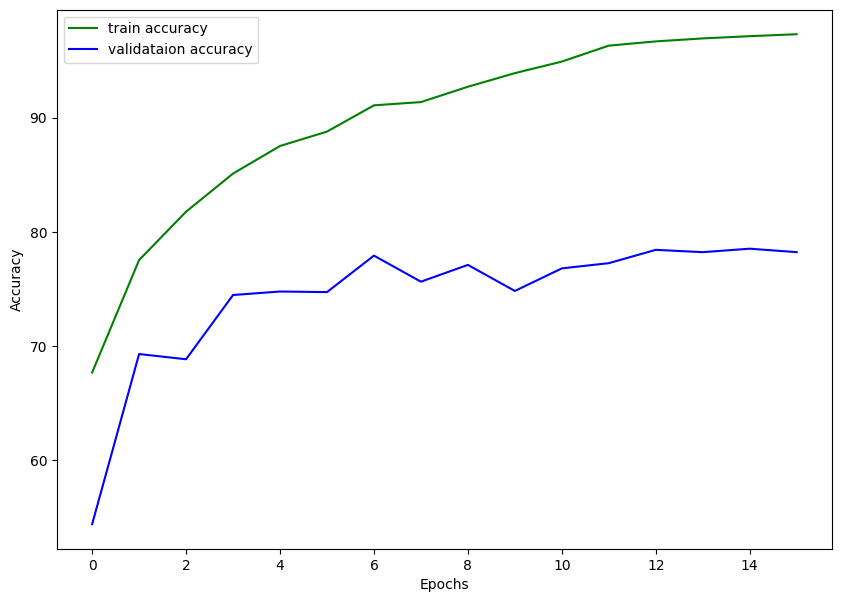

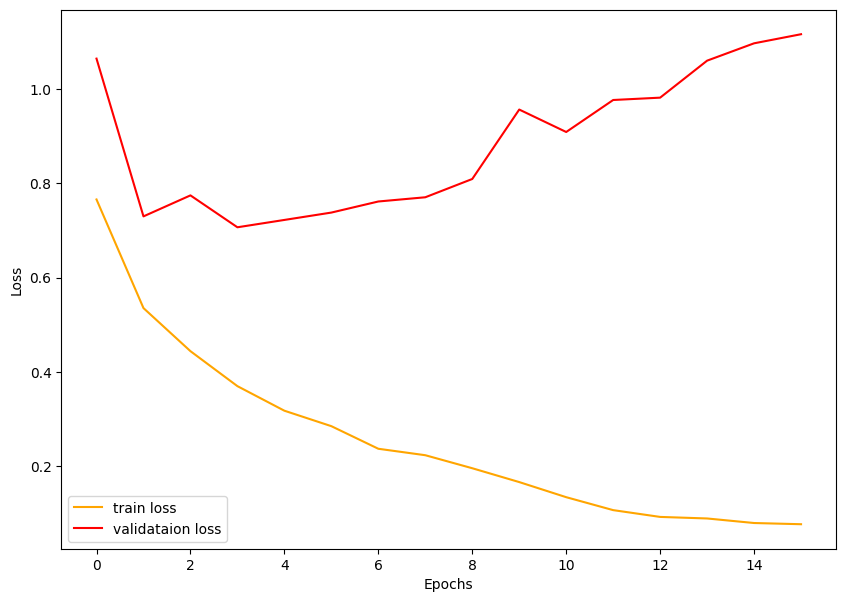

In [15]:
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5,min_lr=1e-8)
early_stopping = EarlyStopping(patience=12, min_delta=0.001, save_path='outputs/resnet18/best_model.pt')
epochs = 50
for epoch in range(epochs):
    print(f"\n[INFO] Epoch {epoch+1}/{epochs}")

    train_epoch_loss, train_epoch_acc = train(model, train_loader, optimizer, criterion)
    valid_epoch_loss, valid_epoch_acc = validate(model, valid_loader, criterion)

    scheduler.step(valid_epoch_loss)

    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)

    print(f"Training loss: {train_epoch_loss:.4f}, acc: {train_epoch_acc:.2f}%")
    print(f"Validation loss: {valid_epoch_loss:.4f}, acc: {valid_epoch_acc:.2f}%")
    for g in optimizer.param_groups:
        print(f"Learning rate: {g['lr']:.6f}")

    # Early stopping
    early_stopping(valid_epoch_loss, model)
    if early_stopping.early_stop:
        print("[INFO] Early stopping triggered.")
        break
# save the trained model weights
save_model(epochs, model, optimizer, criterion)
# save the loss and accuracy plots
save_plots(train_acc, valid_acc, train_loss, valid_loss,eff_net='resnet18')
print('TRAINING COMPLETE')

Accuracy: 0.7821681864235056
                precision    recall  f1-score   support

Người lớn tuổi       0.80      0.71      0.75       240
    Thanh niên       0.84      0.88      0.86       956
    Thiếu niên       0.47      0.56      0.51       106
    Trung niên       0.62      0.63      0.62       383
        Trẻ em       0.96      0.80      0.88       289

      accuracy                           0.78      1974
     macro avg       0.74      0.72      0.72      1974
  weighted avg       0.79      0.78      0.78      1974



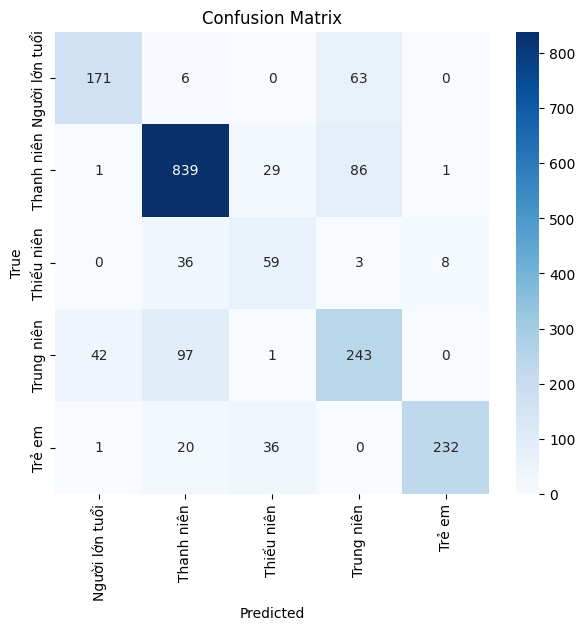

In [16]:
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Metrics
class_names = valid_dataset.classes
print("Accuracy:", accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# ResNet-34

In [19]:
resnet34 = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)

# Freeze backbone
for param in resnet34.parameters():
    param.requires_grad = False

# Replace classifier
in_features = resnet34.fc.in_features
resnet18.fc = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, 5)
)

# Unfreeze last residual block (layer4)
for param in resnet34.parameters():
    param.requires_grad = True
model = resnet34.to(device)

optimizer = optim.AdamW([
    {"params": model.layer1.parameters(), "lr": 1e-5},
    {"params": model.layer2.parameters(), "lr": 3e-5},
    {"params": model.layer3.parameters(), "lr": 5e-5},
    {"params": model.layer4.parameters(), "lr": 1e-4},
    {"params": model.fc.parameters(), "lr": 1e-3},
],weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [20]:
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")


21,797,672 total parameters.
21,797,672 training parameters.



[INFO] Epoch 1/50
Training


100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [00:23<00:00, 10.50it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:02<00:00, 11.34it/s]


Training loss: 0.8865, acc: 68.87%
Validation loss: 0.9637, acc: 59.52%
Learning rate: 0.000010
Learning rate: 0.000030
Learning rate: 0.000050
Learning rate: 0.000100
Learning rate: 0.001000
[INFO] Validation loss decreased. Saving model to outputs/resnet34/best_model.pt

[INFO] Epoch 2/50
Training


100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [00:23<00:00, 10.47it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:02<00:00, 11.27it/s]


Training loss: 0.4977, acc: 79.34%
Validation loss: 0.7201, acc: 71.83%
Learning rate: 0.000010
Learning rate: 0.000030
Learning rate: 0.000050
Learning rate: 0.000100
Learning rate: 0.001000
[INFO] Validation loss decreased. Saving model to outputs/resnet34/best_model.pt

[INFO] Epoch 3/50
Training


100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [00:23<00:00, 10.33it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:02<00:00, 10.50it/s]


Training loss: 0.3999, acc: 84.11%
Validation loss: 0.6205, acc: 76.34%
Learning rate: 0.000010
Learning rate: 0.000030
Learning rate: 0.000050
Learning rate: 0.000100
Learning rate: 0.001000
[INFO] Validation loss decreased. Saving model to outputs/resnet34/best_model.pt

[INFO] Epoch 4/50
Training


100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [00:23<00:00, 10.41it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:02<00:00, 11.40it/s]


Training loss: 0.3311, acc: 86.77%
Validation loss: 0.7040, acc: 75.03%
Learning rate: 0.000010
Learning rate: 0.000030
Learning rate: 0.000050
Learning rate: 0.000100
Learning rate: 0.001000
[INFO] EarlyStopping counter: 1 out of 12

[INFO] Epoch 5/50
Training


100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [00:23<00:00, 10.39it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:02<00:00, 10.96it/s]


Training loss: 0.2781, acc: 89.26%
Validation loss: 0.7398, acc: 77.05%
Learning rate: 0.000010
Learning rate: 0.000030
Learning rate: 0.000050
Learning rate: 0.000100
Learning rate: 0.001000
[INFO] EarlyStopping counter: 2 out of 12

[INFO] Epoch 6/50
Training


100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [00:23<00:00, 10.38it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:02<00:00, 11.27it/s]


Training loss: 0.2313, acc: 91.07%
Validation loss: 0.8320, acc: 75.08%
Learning rate: 0.000010
Learning rate: 0.000030
Learning rate: 0.000050
Learning rate: 0.000100
Learning rate: 0.001000
[INFO] EarlyStopping counter: 3 out of 12

[INFO] Epoch 7/50
Training


100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [00:23<00:00, 10.35it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:02<00:00, 11.02it/s]


Training loss: 0.2022, acc: 92.12%
Validation loss: 0.7833, acc: 77.36%
Learning rate: 0.000010
Learning rate: 0.000030
Learning rate: 0.000050
Learning rate: 0.000100
Learning rate: 0.001000
[INFO] EarlyStopping counter: 4 out of 12

[INFO] Epoch 8/50
Training


100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [00:23<00:00, 10.34it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:02<00:00, 11.47it/s]


Training loss: 0.1858, acc: 92.97%
Validation loss: 0.8941, acc: 74.77%
Learning rate: 0.000010
Learning rate: 0.000030
Learning rate: 0.000050
Learning rate: 0.000100
Learning rate: 0.001000
[INFO] EarlyStopping counter: 5 out of 12

[INFO] Epoch 9/50
Training


100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [00:23<00:00, 10.37it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:02<00:00, 10.61it/s]


Training loss: 0.1576, acc: 94.21%
Validation loss: 0.8111, acc: 75.43%
Learning rate: 0.000005
Learning rate: 0.000015
Learning rate: 0.000025
Learning rate: 0.000050
Learning rate: 0.000500
[INFO] EarlyStopping counter: 6 out of 12

[INFO] Epoch 10/50
Training


100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [00:23<00:00, 10.32it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:02<00:00, 10.72it/s]


Training loss: 0.1076, acc: 96.14%
Validation loss: 0.8337, acc: 76.80%
Learning rate: 0.000005
Learning rate: 0.000015
Learning rate: 0.000025
Learning rate: 0.000050
Learning rate: 0.000500
[INFO] EarlyStopping counter: 7 out of 12

[INFO] Epoch 11/50
Training


100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [00:23<00:00, 10.39it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:03<00:00, 10.28it/s]


Training loss: 0.0898, acc: 96.83%
Validation loss: 0.8773, acc: 78.47%
Learning rate: 0.000005
Learning rate: 0.000015
Learning rate: 0.000025
Learning rate: 0.000050
Learning rate: 0.000500
[INFO] EarlyStopping counter: 8 out of 12

[INFO] Epoch 12/50
Training


100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [00:23<00:00, 10.45it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:02<00:00, 10.96it/s]


Training loss: 0.0701, acc: 97.59%
Validation loss: 0.8863, acc: 77.66%
Learning rate: 0.000005
Learning rate: 0.000015
Learning rate: 0.000025
Learning rate: 0.000050
Learning rate: 0.000500
[INFO] EarlyStopping counter: 9 out of 12

[INFO] Epoch 13/50
Training


100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [00:23<00:00, 10.35it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:02<00:00, 10.96it/s]


Training loss: 0.0707, acc: 97.49%
Validation loss: 0.9115, acc: 79.84%
Learning rate: 0.000005
Learning rate: 0.000015
Learning rate: 0.000025
Learning rate: 0.000050
Learning rate: 0.000500
[INFO] EarlyStopping counter: 10 out of 12

[INFO] Epoch 14/50
Training


100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [00:23<00:00, 10.52it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:02<00:00, 11.27it/s]


Training loss: 0.0591, acc: 97.95%
Validation loss: 0.9766, acc: 78.12%
Learning rate: 0.000005
Learning rate: 0.000015
Learning rate: 0.000025
Learning rate: 0.000050
Learning rate: 0.000500
[INFO] EarlyStopping counter: 11 out of 12

[INFO] Epoch 15/50
Training


100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [00:23<00:00, 10.44it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:02<00:00, 10.96it/s]


Training loss: 0.0613, acc: 97.80%
Validation loss: 0.9918, acc: 78.37%
Learning rate: 0.000003
Learning rate: 0.000008
Learning rate: 0.000013
Learning rate: 0.000025
Learning rate: 0.000250
[INFO] EarlyStopping counter: 12 out of 12
[INFO] Early stopping triggered.
TRAINING COMPLETE


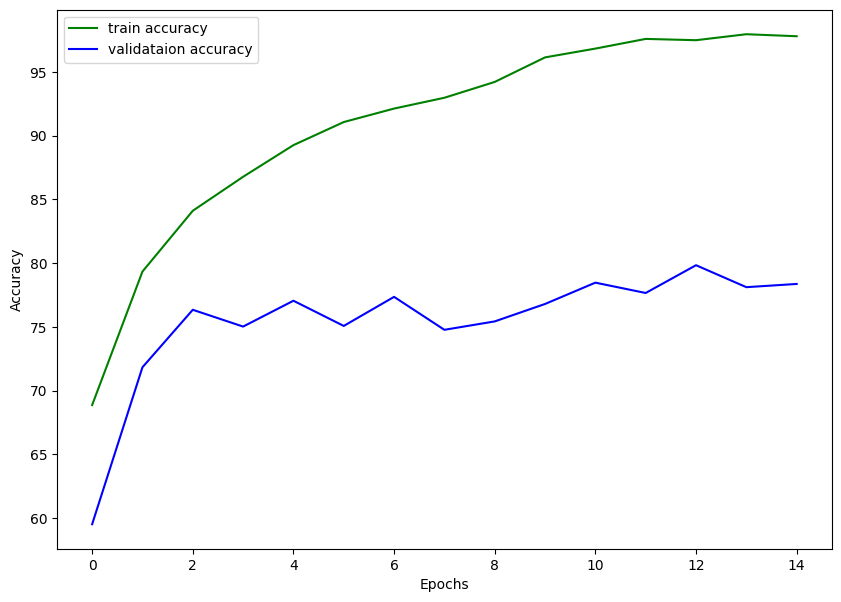

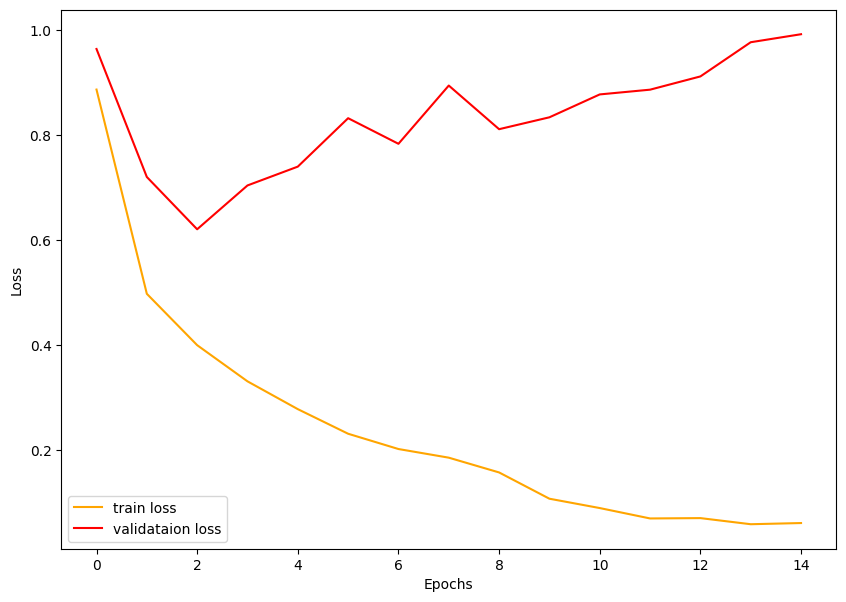

In [23]:
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5,min_lr=1e-8)
early_stopping = EarlyStopping(patience=12, min_delta=0.001, save_path='outputs/resnet34/best_model.pt')
epochs = 50
for epoch in range(epochs):
    print(f"\n[INFO] Epoch {epoch+1}/{epochs}")

    train_epoch_loss, train_epoch_acc = train(model, train_loader, optimizer, criterion)
    valid_epoch_loss, valid_epoch_acc = validate(model, valid_loader, criterion)

    scheduler.step(valid_epoch_loss)

    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)

    print(f"Training loss: {train_epoch_loss:.4f}, acc: {train_epoch_acc:.2f}%")
    print(f"Validation loss: {valid_epoch_loss:.4f}, acc: {valid_epoch_acc:.2f}%")
    for g in optimizer.param_groups:
        print(f"Learning rate: {g['lr']:.6f}")

    # Early stopping
    early_stopping(valid_epoch_loss, model)
    if early_stopping.early_stop:
        print("[INFO] Early stopping triggered.")
        break
# save the trained model weights
save_model(epochs, model, optimizer, criterion)
# save the loss and accuracy plots
save_plots(train_acc, valid_acc, train_loss, valid_loss,eff_net='resnet34')
print('TRAINING COMPLETE')

Accuracy: 0.7836879432624113
                precision    recall  f1-score   support

Người lớn tuổi       0.73      0.81      0.77       240
    Thanh niên       0.85      0.85      0.85       956
    Thiếu niên       0.52      0.48      0.50       106
    Trung niên       0.61      0.58      0.59       383
        Trẻ em       0.94      0.92      0.93       289

      accuracy                           0.78      1974
     macro avg       0.73      0.73      0.73      1974
  weighted avg       0.78      0.78      0.78      1974



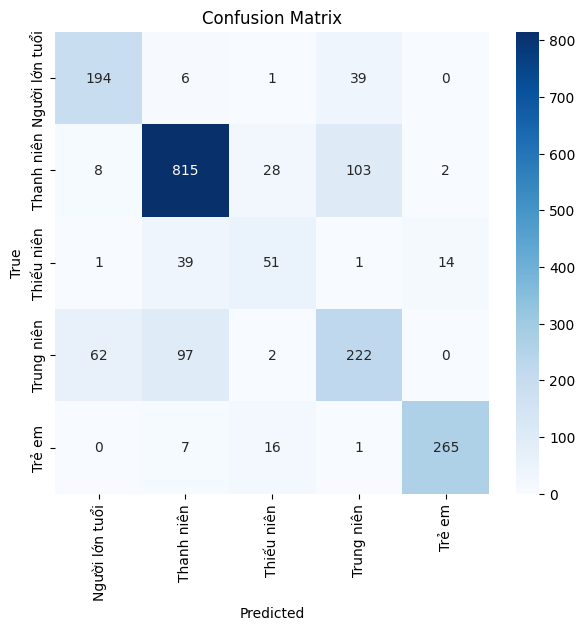

In [24]:
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Metrics
class_names = valid_dataset.classes
print("Accuracy:", accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()